![MLU Logo](https://drive.corp.amazon.com/view/bwernes@/MLU_Logo.png?download=true)

# <a name="0">Machine Learning Accelerator - Tabular Data - Lecture 1</a>

## Final Project:  K Nearest Neighbors (KNN)

Build a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) to predict the __label__ field (substitute or not substitute) of the Amazon product substitute dataset.

### Final Project Problem: Product Substitute Prediction

__Problem Definition__:
Given a pair of products, (A, B), we say that B is a "substitute" for A if a customer would buy B in place of A -- say, if A were out of stock.

The goal of this project is to predict a substitute relationship between pairs of products. Complete the tasks in this notebook and submit your model's predictions as a CSV file to the leaderboard: __https://mlu.corp.amazon.com/contests/redirect/35__

1. <a href="#1">Read the datasets</a> (Given) 
2. <a href="#2">Data Processing</a> (Implement)
    * <a href="#21">Exploratory Data Analysis</a>
    * <a href="#22">Select features to build the model</a> (Suggested)
    * <a href="#23">Train - Validation - Test Datasets</a>
    * <a href="#24">Data Processing with Pipeline</a>
3. <a href="#3">Train (and Tune) a Classifier on the Training Dataset</a> (Implement)
4. <a href="#3">Make Predictions on the Test Dataset</a> (Implement)
5. <a href="#4">Write the Test Predictions to a CSV file</a> (Given)


__Datasets and Files:__


* __training.csv__: Training data with product pair features and corresponding labels:
> - `ID:` ID of the record
> - `label:` Tells whether the key and candidate products are substitutes (1) or not (0).
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __public_test_features.csv__: Test data with product pairs features __without__ labels:
> - `ID:` ID of the record
> - `key_asin ...:` Key product ASIN features 
> - `cand_asin ...:` Candidate product ASIN features 


* __metadata-dataset.xlsx__: Provides detailed information about all key_ and cand_ columns in the training and test sets. Try to select some useful features to include in the model, as not all of them are suitable. `|Region Id|MarketPlace Id|ASIN|Binding Code|binding_description|brand_code|case_pack_quantity|, ...`


* __Sample submission file:__ You can see a sample file: sample-submission.csv under data/final_project folder.

## 1. <a name="1">Read the datasets</a> (Given)
(<a href="#0">Go to top</a>)

Then, we read the __training__ and __test__ datasets into dataframes, using [Pandas](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). This library allows us to read and manipulate our data.

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings("ignore")
  
training_data = pd.read_csv('../../data/final_project/training.csv')
test_data = pd.read_csv('../../data/final_project/public_test_features.csv')

print('The shape of the training dataset is:', training_data.shape)
print('The shape of the test dataset is:', test_data.shape)

The shape of the training dataset is: (36803, 228)
The shape of the test dataset is: (15774, 227)


## 2. <a name="2">Data Processing</a> (Implement)
(<a href="#0">Go to top</a>) 

### 2.1 <a name="21">Exploratory Data Analysis</a>
(<a href="#2">Go to Data Processing</a>)

We look at number of rows, columns, and some simple statistics of the datasets.

In [2]:
training_data.head()

,ID,label,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,34016,0,1,1,B00YCZ6IKA,kitchen,Kitchen,NICLW,NaN,base_product,...,0.529104,pounds,5.118110,NaN,18-Apr-13,14-Oct-17,N,13-Oct-17,2867,NaN
1,3581,0,1,1,B00U25WT7A,office_product,Office Product,NaN,NaN,base_product,...,0.100000,pounds,4.500000,NaN,19-May-16,21-Mar-18,N,20-Mar-18,65,NaN
2,36025,1,1,1,B011BZ3GXU,consumer_electronics,Electronics,NaN,NaN,base_product,...,0.654773,pounds,3.937008,NaN,10-Dec-15,16-Feb-18,N,15-Feb-18,1532,NaN
3,42061,1,1,1,B0089XDG3I,pc,Personal Computers,NaN,NaN,base_product,...,3.549442,pounds,10.314961,NaN,19-Oct-12,15-Feb-18,N,14-Feb-18,13964,NaN
4,14628,1,1,1,B014UTSBZW,miscellaneous,Misc.,ZUKC7,1.0,base_product,...,0.396832,pounds,5.196850,NaN,26-Jul-12,9-Mar-18,N,9-Mar-18,1253,NaN


In [3]:
test_data.head()

,ID,key_Region Id,key_MarketPlace Id,key_ASIN,key_Binding Code,key_binding_description,key_brand_code,key_case_pack_quantity,key_classification_code,key_classification_description,...,cand_pkg_weight,cand_pkg_weight_uom,cand_pkg_width,cand_release_date_embargo_level,cand_dw_creation_date,cand_dw_last_updated,cand_is_deleted,cand_last_updated,cand_version,cand_external_testing_certification
0,35057,1,1,B0096M8VR2,pc,Personal Computers,NaN,1.0,base_product,Base Product,...,0.925932,pounds,5.826772,NaN,10-Apr-13,5-Jul-16,N,4-Jul-16,699,NaN
1,41573,1,1,B00EAQJCWW,kitchen,Kitchen,BUNN9,2.0,base_product,Base Product,...,NaN,NaN,NaN,NaN,17-Mar-16,17-Mar-16,N,17-Mar-16,2,NaN
2,44029,1,1,B013P93YOQ,toy,Toy,NaN,NaN,base_product,Base Product,...,NaN,NaN,NaN,NaN,23-Dec-15,2-Dec-17,N,2-Dec-17,17,NaN
3,6462,1,1,B00SKJPKGW,wireless_phone_accessory,Wireless Phone Accessory,PIQ22,1.0,base_product,Base Product,...,6.250000,pounds,9.700000,NaN,22-Jan-15,18-Jan-17,N,18-Jan-17,25351,NaN
4,17533,1,1,B001DCEKXM,sports,Sports,SUUNR,1.0,base_product,Base Product,...,0.176368,pounds,3.228346,NaN,4-Jan-11,16-Nov-17,N,16-Nov-17,7424,NaN


In [4]:
# Implement more EDA here
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36803 entries, 0 to 36802
Columns: 228 entries, ID to cand_external_testing_certification
dtypes: float64(90), int64(12), object(126)
memory usage: 64.0+ MB


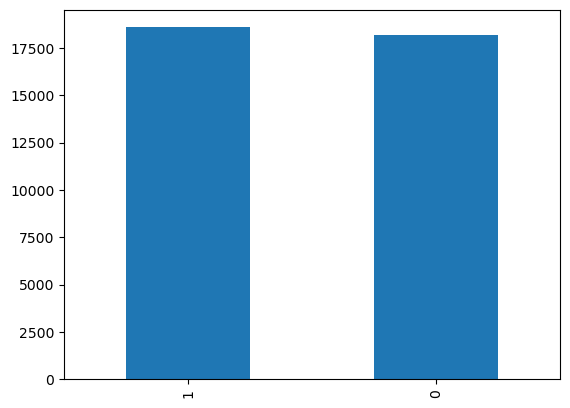

In [7]:
import matplotlib.pyplot as plt

training_data['label'].value_counts().plot.bar()
plt.show()

In [9]:
import numpy as np                    
np.set_printoptions(threshold=np.inf) # use this for datasets with more columns, to print all columns

# This prints the column labels of the features identified as numerical
print('Numerical columns:')
print(training_data.select_dtypes(include=np.number).columns.values)

# This prints the column labels of the features identified as numerical
print('Categorical columns:')
print(training_data.select_dtypes(include='object').columns.values)

Numerical columns:
['ID' 'label' 'key_Region Id' 'key_MarketPlace Id'
 'key_case_pack_quantity' 'key_country_of_origin' 'key_discontinued_date'
 'key_ean' 'key_excluded_direct_browse_node_id' 'key_fedas_id'
 'key_fma_qualified_price_max' 'key_Product Group Code' 'key_isbn'
 'key_item_classification_id' 'key_item_display_diameter'
 'key_item_display_height' 'key_item_display_length'
 'key_item_display_volume' 'key_item_display_weight'
 'key_item_display_width' 'key_item_height' 'key_item_length'
 'key_item_package_quantity' 'key_item_weight' 'key_item_width'
 'key_manufacturer_sku' 'key_max_weight_recommendation'
 'key_min_weight_recommendation' 'key_monthly_recurring_charge'
 'key_number_of_items' 'key_number_of_licenses' 'key_number_of_pages'
 'key_number_of_points' 'key_preferred_vendor' 'key_product_type_id'
 'key_publication_day' 'key_publication_month' 'key_publication_year'
 'key_publisher' 'key_recall_external_identifier'
 'key_recall_notice_expiration_date' 'key_recall_notice_p

### 2.2 <a name="22">Select features to build the model</a> 
(<a href="#2">Go to Data Processing</a>)

For a quick start, we recommend using only a few of the numerical features for both key_ and cand_ ASINs: __item_package_quantity__, __item_height__, __item_width__, __item_length__, __item_weight__, __pkg_height__, __pkg_width__, __pkg_length__, __pkg_weight__. Feel free to explore other fields from the metadata-dataset.xlsx file.


In [10]:
# Grab model features/inputs and target/output
numerical_features = ["key_item_package_quantity", 
                      "key_item_height", "key_item_width", "key_item_length", "key_item_weight", 
                      "key_pkg_height", "key_pkg_width", "key_pkg_length", "key_pkg_weight",
                      "cand_item_package_quantity", 
                      "cand_item_height", "cand_item_width", "cand_item_length", "cand_item_weight", 
                      "cand_pkg_height", "cand_pkg_width", "cand_pkg_length", "cand_pkg_weight"]

model_features = numerical_features
model_target = 'label'

### 2.3 <a name="23">Train - Validation Datasets</a>
(<a href="#2">Go to Data Processing</a>)

We already have training and test datasets, however the test dataset is missing the labels - the goal of the project is to predict these labels and submit them to leaderboard to get scored. 

To produce a validation set to evaluate model performance before submitting to the leaderboard, split the training dataset into train and validation subsets using sklearn's [train_test_split()](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) function. Validation data you get here will be used later in section 3 to tune your classifier.

In [27]:
# Implement here
from sklearn.model_selection import train_test_split

train_data, val_data = train_test_split(training_data, test_size=0.15, shuffle=True, random_state=88)

# Print the shapes of the Train - Validation - Test Datasets
print('Train - Validation - Test Datasets shapes: ', train_data.shape, val_data.shape, test_data.shape)

Train - Validation - Test Datasets shapes:  (31282, 228) (5521, 228) (15774, 227)


### 2.4 <a name="24">Data processing with Pipeline</a>
(<a href="#2">Go to Data Processing</a>)

Build a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html)  to impute the missing values and scale the numerical features, and finally train a [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)  on the imputed and scaled dataset. 


In [30]:
# Implement here
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

### PIPELINE ###
################

# Pipeline desired data transformers, along with an estimator at the end
# For each step specify: a name, the actual transformer/estimator with its parameters
classifier = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    ('scaler', MinMaxScaler()),
    ('estimator', KNeighborsClassifier(n_neighbors = 9))
])

## 3. <a name="3">Train (and Tune) a Classifier</a> (Implement)
(<a href="#0">Go to top</a>)

Train and tune the [K Nearest Neighbors Classifier](https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html) pipeline. The __"Model Tuning"__ section of the __MLA-TAB-Lecture1-KNN.ipynb__ can be useful here. You can loop over different K values and check validation accuracy each time and select best performing K.

In [31]:
# Implement here
# Get train data to train the classifier
X_train = train_data[model_features]
y_train = train_data[model_target]

# Fit the classifier to the train data
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to fit the model
classifier.fit(X_train, y_train)

Pipeline(steps=[('imputer', SimpleImputer()), ('scaler', MinMaxScaler()),
                ('estimator', KNeighborsClassifier(n_neighbors=9))])

In [32]:
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score

# Use the fitted model to make predictions on the train dataset
# Train data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
train_predictions = classifier.predict(X_train)

print('Model performance on the train set:')
print(confusion_matrix(y_train, train_predictions))
print(classification_report(y_train, train_predictions))
print("Train accuracy:", accuracy_score(y_train, train_predictions))

Model performance on the train set:
[[10075  5434]
 [ 3742 12031]]
              precision    recall  f1-score   support

           0       0.73      0.65      0.69     15509
           1       0.69      0.76      0.72     15773

    accuracy                           0.71     31282
   macro avg       0.71      0.71      0.71     31282
weighted avg       0.71      0.71      0.71     31282

Train accuracy: 0.7066683715874944


In [33]:
X_val = val_data[model_features]
y_val = val_data[model_target]

In [35]:
# Try different values of K and select the one producing the highest metric on the validation set
# (later, we will see how do to this more efficiently with library hyperparameter tuning functions)

K_values = [1, 2, 3, 4, 5, 6, 7, 8, 9]

K_best = 0.0
val_score_best = 0.0
for K in K_values:
    classifier = Pipeline([
        ('imputer', SimpleImputer()),
        ('scaler', MinMaxScaler()),
        ('estimator', KNeighborsClassifier(n_neighbors = K))
            ])
    classifier.fit(X_train, y_train)
    val_predictions = classifier.predict(X_val)
    val_acc = accuracy_score(y_val, val_predictions)
    print("K=%d, Validation accuracy: %f" % (K, val_acc))
    if val_acc > val_score_best:
        K_best = K
        val_score_best = val_acc
        
print("K_best=%d, Best Validation accuracy: %f" % (K_best, val_score_best))

K=1, Validation accuracy: 0.600254
K=2, Validation accuracy: 0.583409
K=3, Validation accuracy: 0.604419
K=4, Validation accuracy: 0.598623
K=5, Validation accuracy: 0.608585
K=6, Validation accuracy: 0.612570
K=7, Validation accuracy: 0.626698
K=8, Validation accuracy: 0.622713
K=9, Validation accuracy: 0.621989
K_best=7, Best Validation accuracy: 0.626698


## 4. <a name="4">Make Predictions on the Test Dataset</a> (Implement)
(<a href="#0">Go to top</a>)

Use the trained classifier to predict the labels on the test set. Test accuracy would be displayed upon a valid submission to the leaderboard.

In [38]:
# Implement here

# Get test data to test the classifier
# ! test data should come from public_test_features.csv !
# ...


# Get test data to test the classifier
X_test = test_data[model_features]

# Use the fitted model to make predictions on the test dataset
# Test data going through the Pipeline it's imputed (with means from the train data), 
#   scaled (with the min/max from the train data), 
#   and finally used to make predictions
test_predictions = classifier.predict(X_test)

# Use the trained model to make predictions on the test dataset
# test_predictions = ...


## 5. <a name="5">Write the test predictions to a CSV file</a> (Given)
(<a href="#0">Go to top</a>)

Use the following code to write the test predictions to a CSV file. Download locally the CSV file from the SageMaker instance, and upload it to __https://mlu.corp.amazon.com/contests/redirect/35__

In [39]:
import pandas as pd

result_df = pd.DataFrame(columns=["ID", "label"])
result_df["ID"] = test_data["ID"].tolist()
result_df["label"] = test_predictions

result_df.to_csv("../../data/project_day1_result.csv", index=False)

In [40]:
print('Double-check submission file against the sample_submission.csv')
sample_submission_df = pd.read_csv('../../data/final_project/sample-submission.csv')
print('Differences between project_day1_result IDs and sample submission IDs:',(sample_submission_df['ID'] != result_df['ID']).sum())

Double-check submission file against the sample_submission.csv
Differences between project_day1_result IDs and sample submission IDs: 0
